# Imports

In [2]:
import numpy as np
import os, glob, json
from typing import Tuple, Iterable
from multiprocessing import Pool, Process
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import time
import random
from sklearn.manifold import TSNE


# Datenimport

In [3]:
def getJsonFileNamesInFolder(path2jsonFiles: str) -> Iterable[str]:
    res = glob.glob(path2jsonFiles)
    return res

In [4]:
a = getJsonFileNamesInFolder("../data/traintest/*.json")
a[1]

'../data/traintest/1662041197516_to_1662466208815_shape_40000_4_sampleRate_4000_durationInSeconds_10.json'

In [5]:
def parseJsonFile(filename: str) -> dict:
    # start_t = time.perf_counter()
    file = open(filename)
    content = json.load(file)
    file.close()
    # end_t = time.perf_counter()
    return content

In [6]:
def parseJsonFiles(filenames: Iterable[str], processes = None, chunksize=None) -> dict:
    start_t = time.perf_counter()
    parsedJsonFiles: dict = dict()

    results = []

    # with Pool() as pool:
    #     results = pool.map(parseJsonFile, filenames)
    
    for filename in filenames:
        temp = parseJsonFile(filename)
        
        results.append(temp)

        # for filename, content, duration in results:
        #     print(f"{filename} completed in {duration:.2f}s")
    end_t = time.perf_counter()
    total_duration = end_t - start_t
    print(f"etl took {total_duration:.2f}s total")
    return results

In [7]:
a = np.ones((5, 3))

In [8]:
a

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [9]:
a[:,0] = [2,2,2,2,2]

In [10]:
a

array([[2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.],
       [2., 1., 1.]])

In [11]:
def createXandY(path2jsonFiles: str) -> Tuple[np.ndarray, np.ndarray]:
    # (filename, dict)
    jsonFilePaths : str = getJsonFileNamesInFolder(path2jsonFiles)
    parsedFilesList = parseJsonFiles(jsonFilePaths)
    
    numberOfFiles = int(len(parsedFilesList))

    

    print(type(parsedFilesList[0]))
    
    
    
    sampleRate = int(parsedFilesList[0]["sampleRate"])
    durationInSeconds = int(parsedFilesList[0]["durationInSeconds"])
    datapointsPerChannel = sampleRate*durationInSeconds
    numberOfChannels = 3

    X = np.empty((numberOfFiles,datapointsPerChannel, numberOfChannels)) # (numberOfFiles, sampleRate*durationInSeconds, numberOfChannels)
    y = np.empty((numberOfFiles,1),dtype=object) #(numberOfFiles, 1)

    for idx, parsedFile in enumerate(parsedFilesList):
        
        X_temp = np.empty((datapointsPerChannel, numberOfChannels))
        
        X_temp[:,0] = parsedFile["x"]
        X_temp[:,1] = parsedFile["y"]
        X_temp[:,2] = parsedFile["z"]

        X[idx] = X_temp

        y[idx] = parsedFile["label"]




    return X,y 


In [12]:
X, y = createXandY("../data/traintest/*.json")

etl took 45.45s total
<class 'dict'>


In [13]:
print(X.shape, y.shape)

(1987, 40000, 3) (1987, 1)


In [14]:
X[0].shape

(40000, 3)

In [15]:
def getIndicesOfFirstOccurranceOfLabel(searchlabel:str, y):
    labels = np.unique(y)
    if searchlabel not in labels:
        raise Exception("invalid label", "available labels: ", labels)
    indices = []
    for idx, label in enumerate(y):
        if label[0] == searchlabel:
            indices.append(idx)
    return indices

## Erste Visualisierung jeder Klasse

In [16]:
def plotRandomDatapointsOfLabel(searchLabel, X, y, type="line", axis=["z"]):
    plt.rcParams["figure.figsize"] = (20, 3)
    #searchLabel = "Gehen"
    
    indices = getIndicesOfFirstOccurranceOfLabel(searchLabel,y)
    randomIndex = random.randint(0, len(indices)-1)
    #randomIndex = indices[3]
    print(y[indices[randomIndex]], "Anzahl Aufnahmen: ", len(indices))
    if type=="line":
        plt.plot(X[indices[randomIndex]][:,2])
        plt.ylabel("Beschleunigung in g")
        plt.xlabel("Anzahl der Datenpunkte")
    plt.show()
    plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]

In [17]:
def plotRandomDatapointsOfEachLabel(X, y, type="line", axis=["z"]):
    labels = np.unique(y)
    for label in labels:
        plotRandomDatapointsOfLabel(label, X, y, type)

['Gehen'] Anzahl Aufnahmen:  235


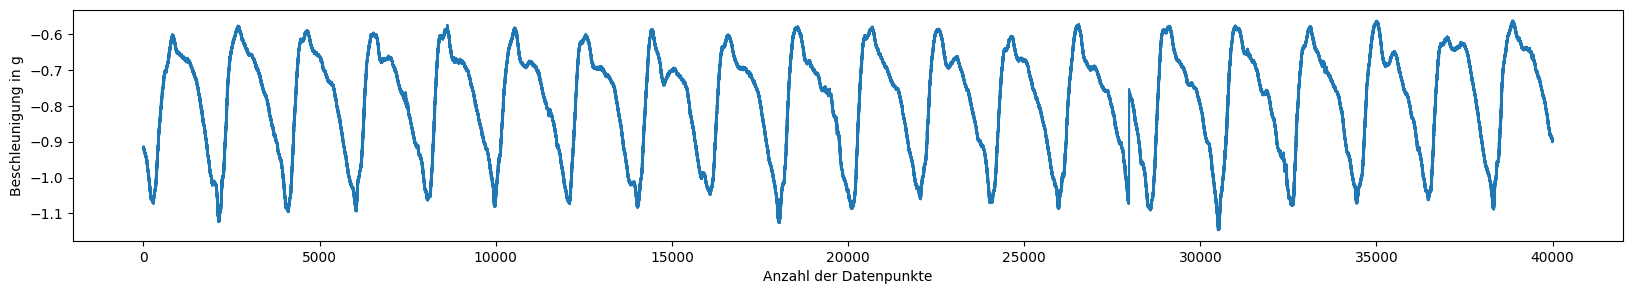

In [18]:
plotRandomDatapointsOfLabel("Gehen", X, y)


['GLT_Rollwagen'] Anzahl Aufnahmen:  241


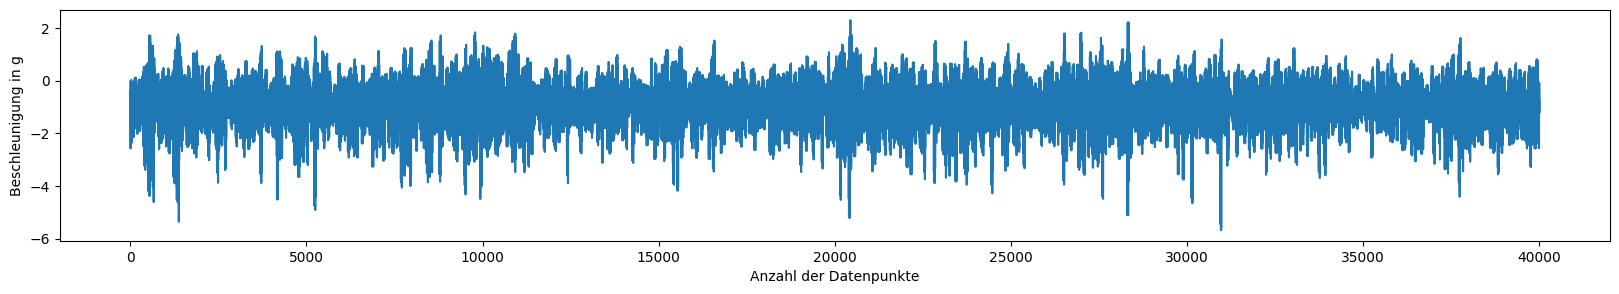

['Gehen'] Anzahl Aufnahmen:  235


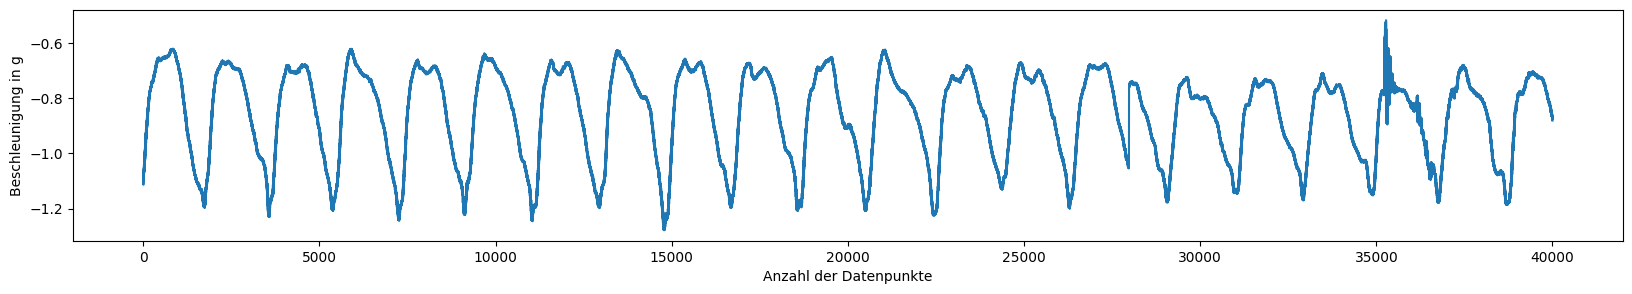

['HebenSenken'] Anzahl Aufnahmen:  130


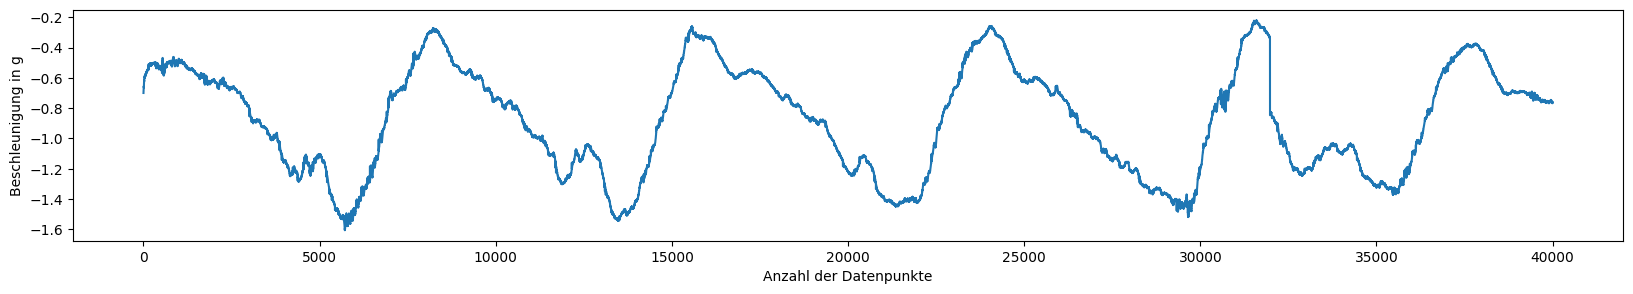

['Hubwagen'] Anzahl Aufnahmen:  257


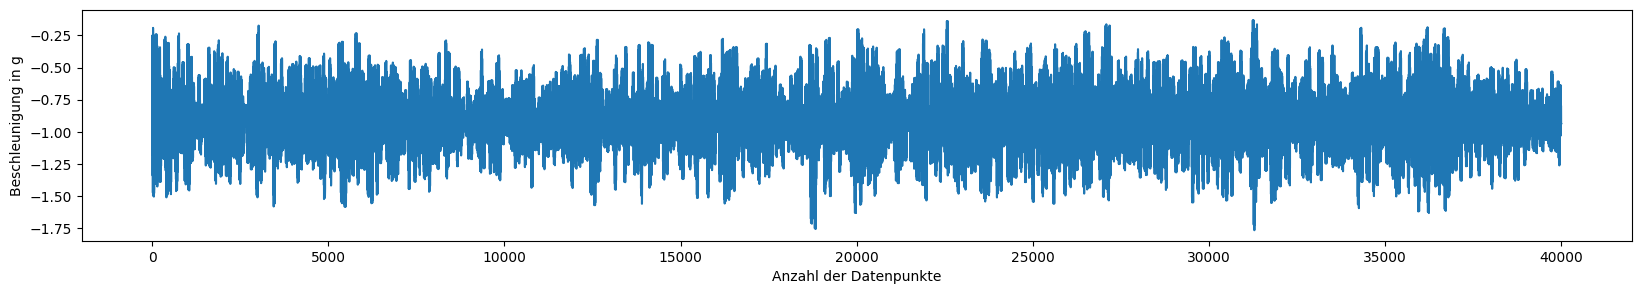

['Kiste liegt'] Anzahl Aufnahmen:  191


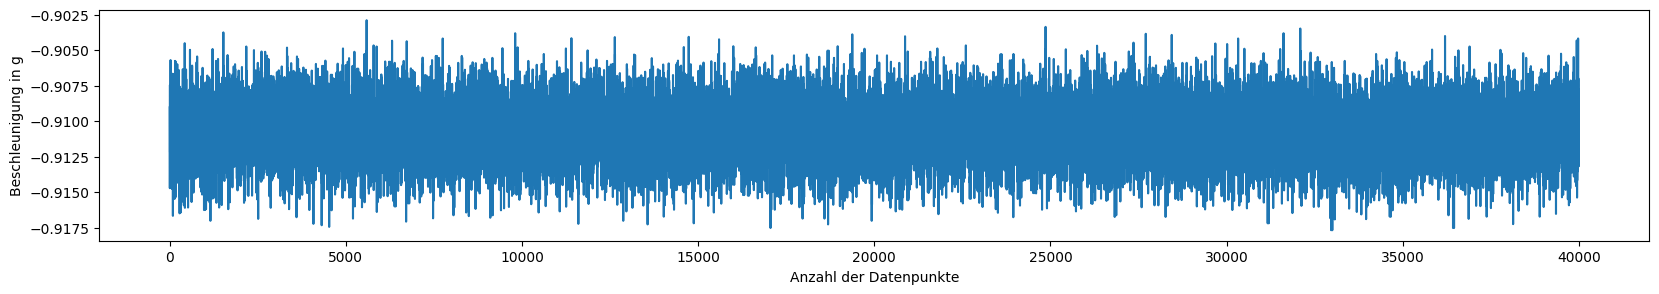

['Rollenbahn'] Anzahl Aufnahmen:  226


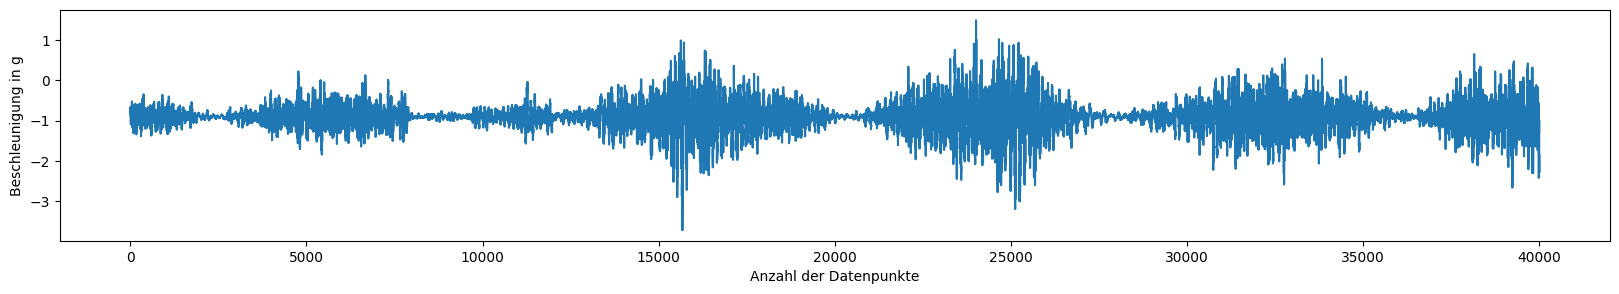

['Rolltisch'] Anzahl Aufnahmen:  218


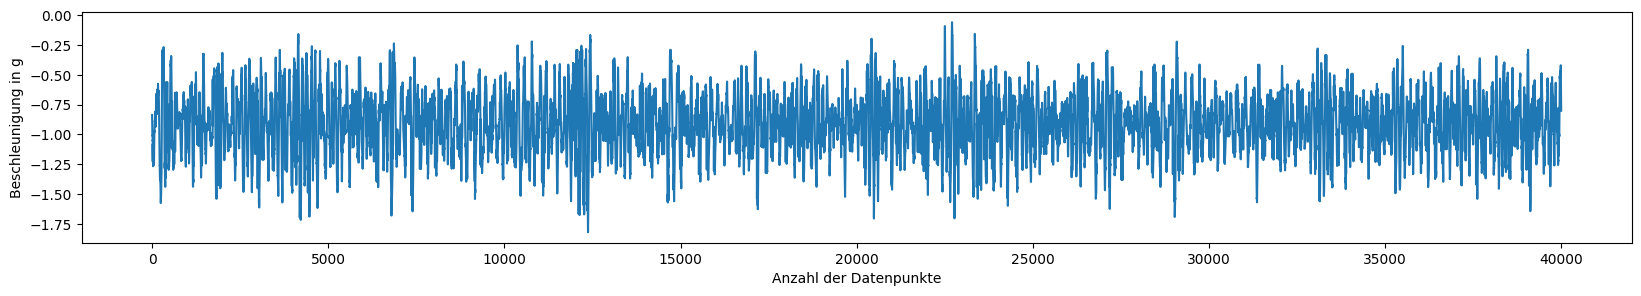

['Sackkarre'] Anzahl Aufnahmen:  248


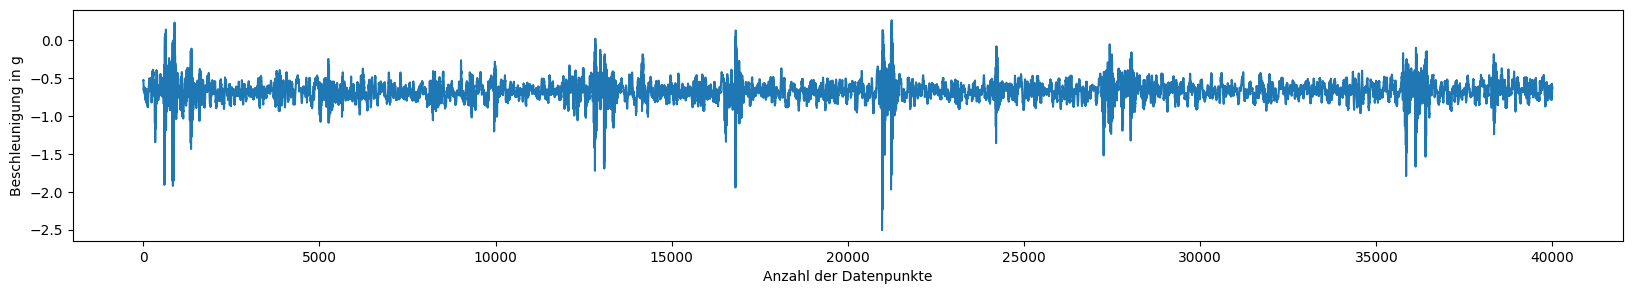

['vert. drehen'] Anzahl Aufnahmen:  241


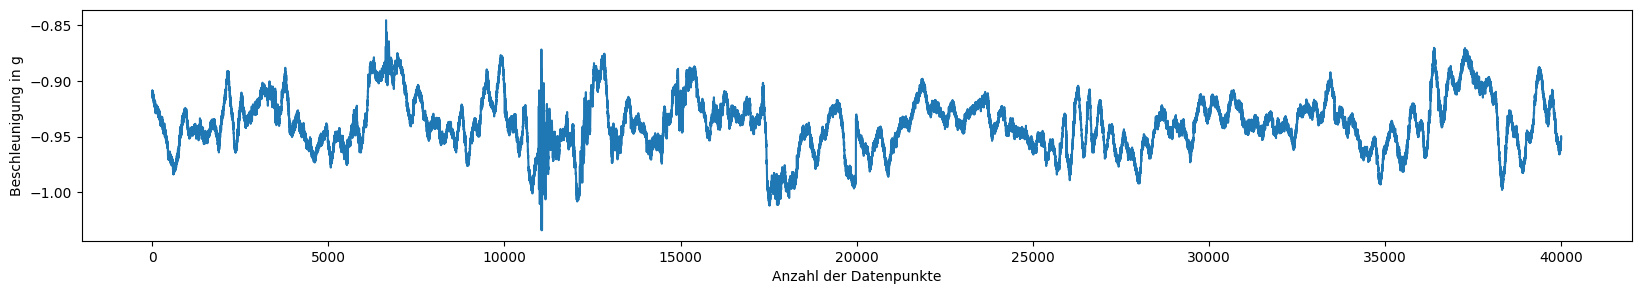

In [19]:
plotRandomDatapointsOfEachLabel(X, y,type="line")

## Fehlerhafte Daten finden und aussortieren

Wie können fehlerhafte Daten gefunden werden [per Boxplots]  und Aufnahmen markieren welche außerhalb der Grenzen liege:
1. per Boxplots
2. Null-Werte finden
3. Aufnahmen mit übernatürlich hohen Werten z.B über 1000 g finden => sichere Ausreißer
2. per Verteilung => welche Aufnahmen weichen vom Charakter von den anderen Aufnahmen der gleichen Klasse ab
1. Durchschnittswert der g-Werte berechnen 

In [20]:
np.NAN!=np.NAN

True

In [21]:
def nullCheck(arr):
    contain = False

    if np.isnan(X).any():
        contain = True

    for i in arr:
        if(i is np.NAN or i is None or i is np.NaN):
            contain = True
            break

    if(contain):
        print("The Array contains NaN values")
    else:
        print("The Array does not contain NaN values")

In [22]:
nullCheck(X)

The Array does not contain NaN values


In [23]:
X.shape

(1987, 40000, 3)

In [24]:
def findIllogicalValues(arr,threshold):    
    indices = []
    
    for idx, recording in enumerate(arr):
        flag = False
        for datapoint in recording: 
            for i, channel in enumerate(datapoint):                
                temp = channel
                if (abs(temp) > threshold):                    
                    flag = True
        if(flag):
            indices.append(idx)
    return indices

In [25]:
badIndices = findIllogicalValues(X, threshold=100)

In [26]:
badIndices

[569, 1205, 1866, 1926]

['HebenSenken']


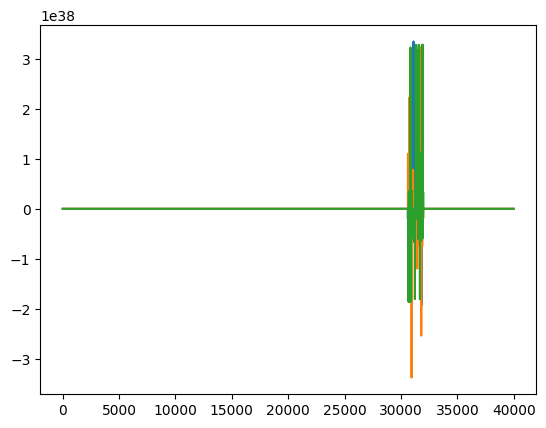

In [27]:
print(y[569])
plt.plot(X[569])
plt.show()

In [28]:
X.shape
X1 = np.delete(X, badIndices, axis=0)
y1 = np.delete(y, badIndices, axis=0)

In [29]:
print(X1.shape, y1.shape)


(1983, 40000, 3) (1983, 1)


['GLT_Rollwagen'] Anzahl Aufnahmen:  241


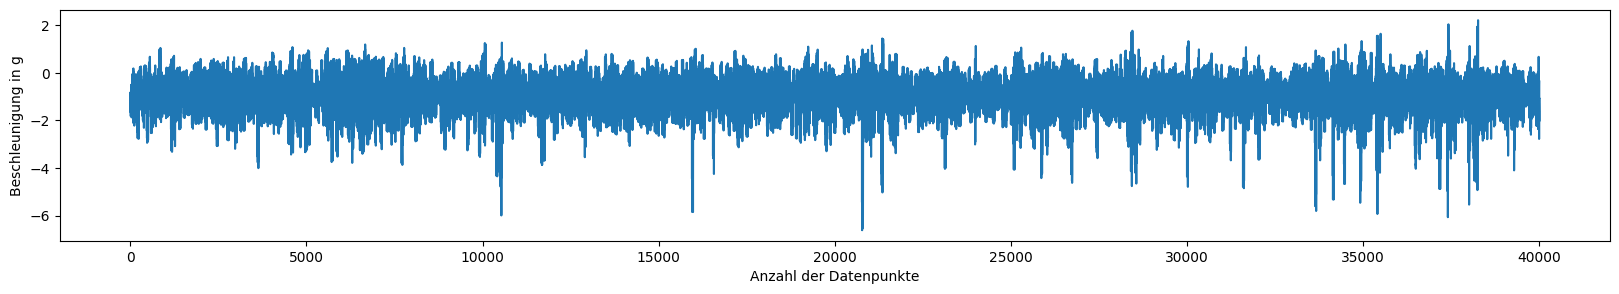

['Gehen'] Anzahl Aufnahmen:  235


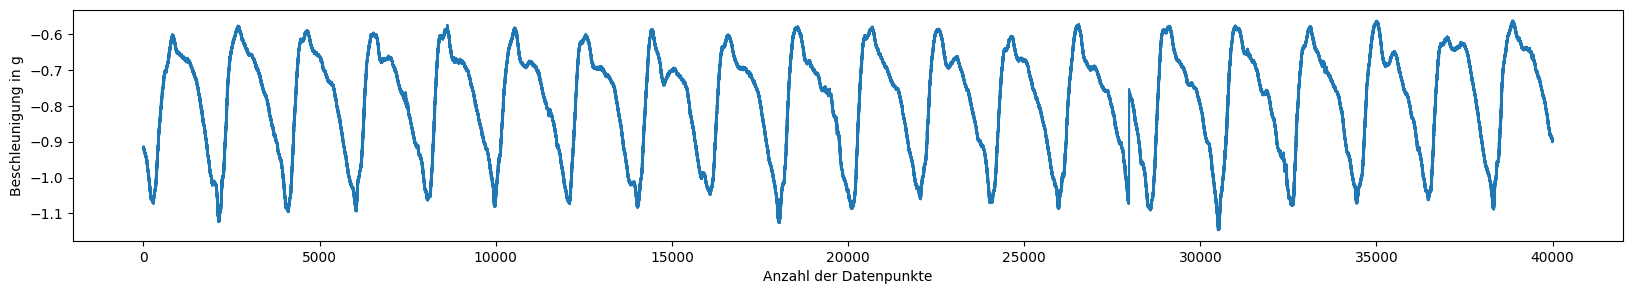

['HebenSenken'] Anzahl Aufnahmen:  128


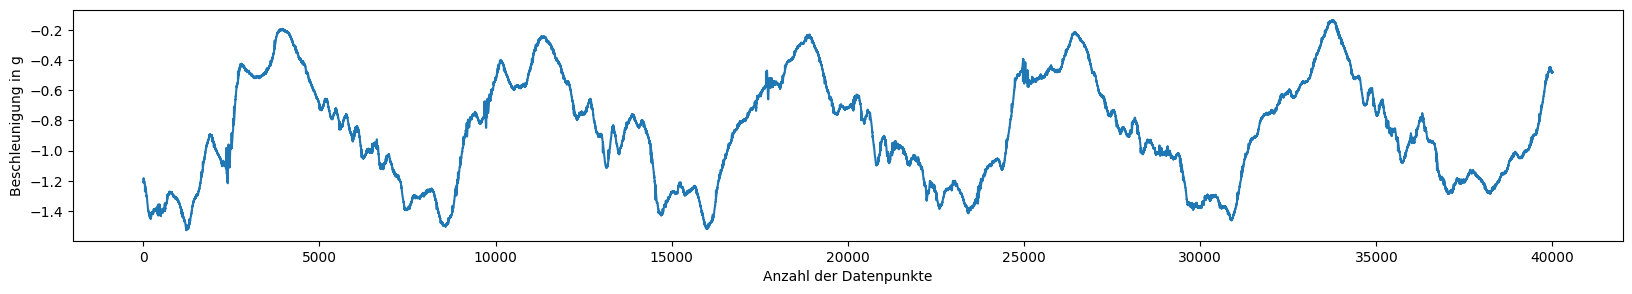

['Hubwagen'] Anzahl Aufnahmen:  257


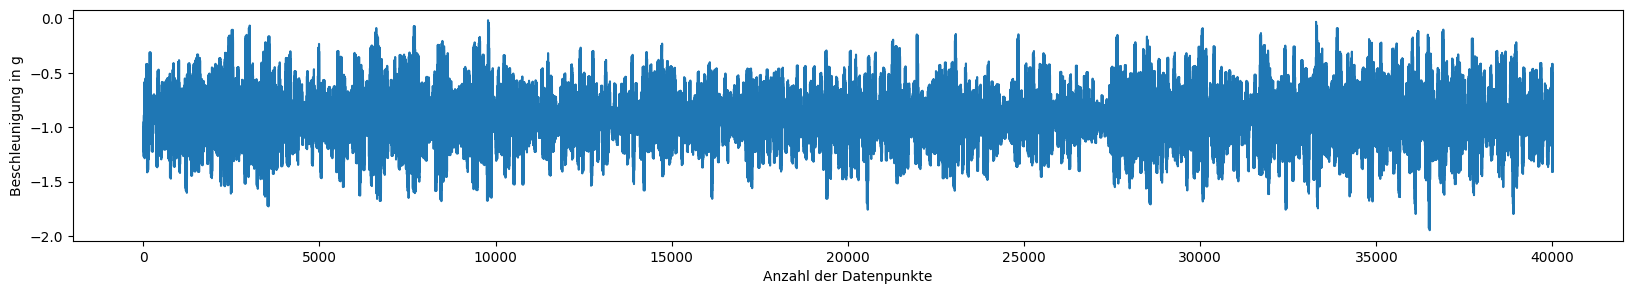

['Kiste liegt'] Anzahl Aufnahmen:  189


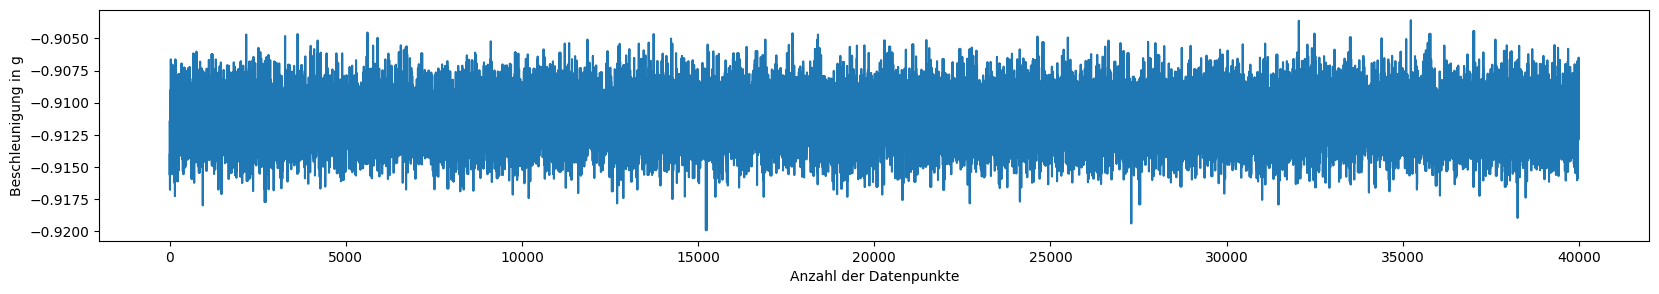

['Rollenbahn'] Anzahl Aufnahmen:  226


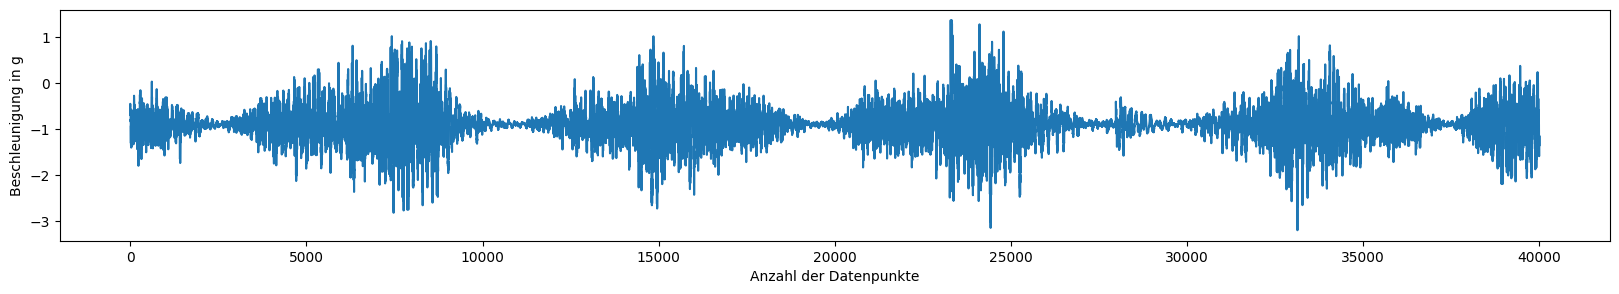

['Rolltisch'] Anzahl Aufnahmen:  218


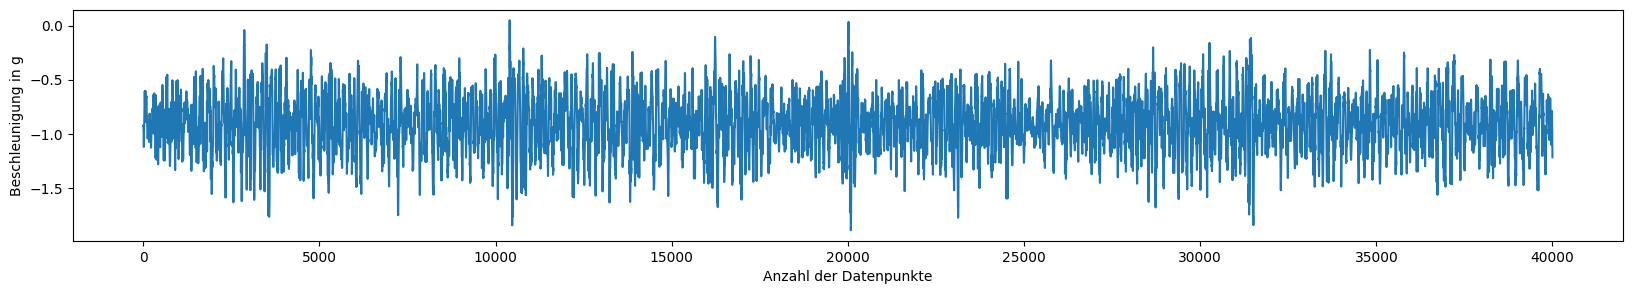

['Sackkarre'] Anzahl Aufnahmen:  248


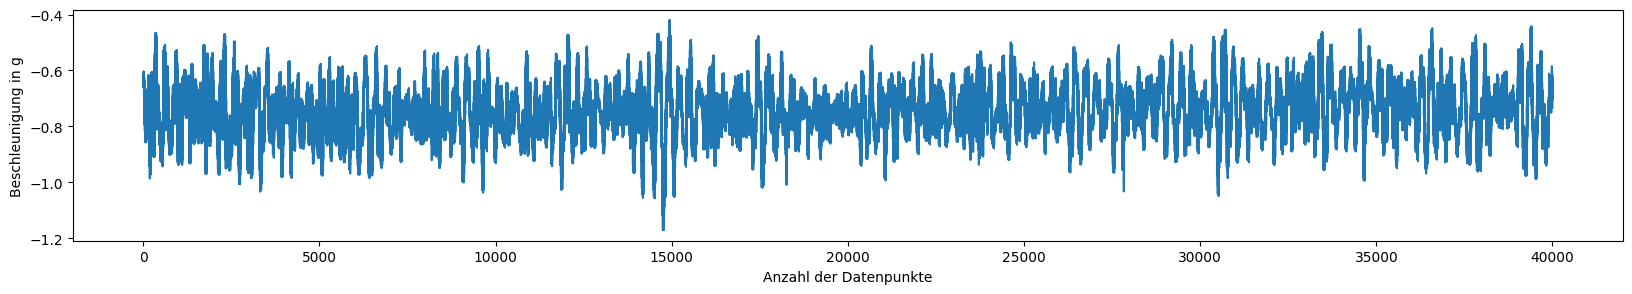

['vert. drehen'] Anzahl Aufnahmen:  241


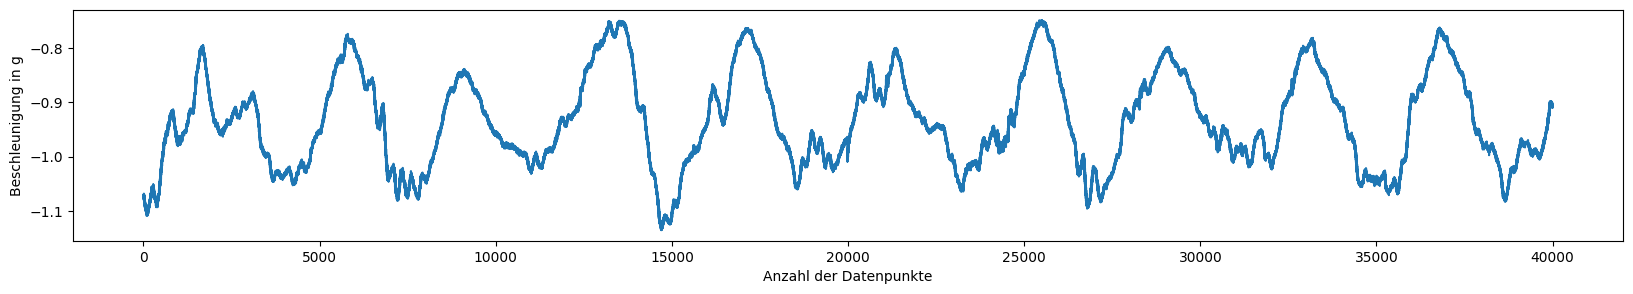

In [30]:
plotRandomDatapointsOfEachLabel(X1, y1)

In [31]:
np.max(X1)

10.223596572875977

## T-SNE

In [32]:
X1[:,:,2].shape

(1983, 40000)

In [51]:
X1 = X1.astype(float)
X1_embedded = TSNE(n_components=2, init='random', n_jobs=-1, perplexity=5).fit_transform(X1[:,:,2])

In [52]:
np.unique(y1)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [53]:
colorLookup = dict.fromkeys(np.unique(y1))

In [54]:
for idx, key in enumerate(colorLookup):
    print(f"{idx} : {key}")
    colorLookup[key] = idx

0 : GLT_Rollwagen
1 : Gehen
2 : HebenSenken
3 : Hubwagen
4 : Kiste liegt
5 : Rollenbahn
6 : Rolltisch
7 : Sackkarre
8 : vert. drehen


In [55]:
colorLookup['Gehen']

1

In [56]:
np.unique(y1)

array(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt',
       'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'],
      dtype=object)

In [57]:
colors = np.zeros(len(X1))
for idx, label in enumerate(y1):    
    colors[idx] = colorLookup[label[0]]

In [58]:
colorLookup.keys()

dict_keys(['GLT_Rollwagen', 'Gehen', 'HebenSenken', 'Hubwagen', 'Kiste liegt', 'Rollenbahn', 'Rolltisch', 'Sackkarre', 'vert. drehen'])

In [59]:
np.unique(colors)

array([0., 1., 2., 3., 4., 5., 6., 7., 8.])

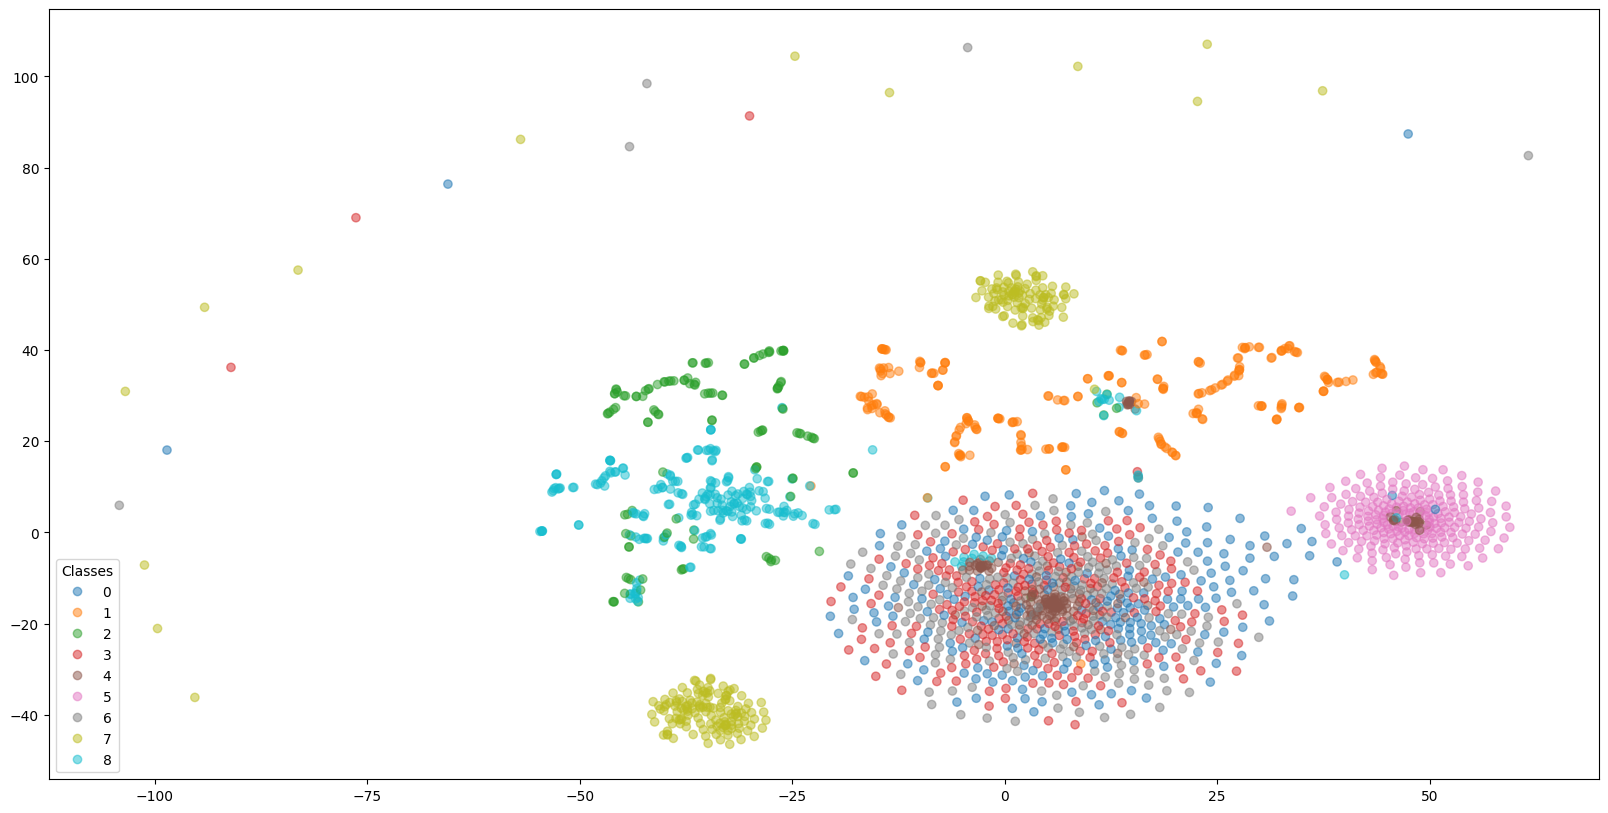

In [61]:

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
scatter = ax.scatter(X1_embedded[:,0], X1_embedded[:,1], c=colors, alpha=0.5, cmap="tab10")
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")

# plt.legend()

plt.show()

In [62]:
for idx, key in enumerate(colorLookup):
    print(f"{idx} : {key}")
    colorLookup[key] = idx

0 : GLT_Rollwagen
1 : Gehen
2 : HebenSenken
3 : Hubwagen
4 : Kiste liegt
5 : Rollenbahn
6 : Rolltisch
7 : Sackkarre
8 : vert. drehen


# Datenvorverarbeitung

# Feature Engineering

# Training

# Evaluierung

# Logging

# Model-Export